# Alanine Multistate
## Example Simulation

This uses the state definition from [1]. 6 states named A,B,C,D,E and F


[1] W.-N. Du, K. A. Marino, and P. G. Bolhuis, “Multiple state transition interface sampling of alanine dipeptide in explicit solvent,” J. Chem. Phys., vol. 135, no. 14, p. 145102, 2011.

### Import and general setup

First we tell the ipython notebook to put figures inside the notebook

In [8]:
!wget https://raw.githubusercontent.com/P2-718na/quantum-folding/master/code/ops/alanine%20multistate/alatools.py
!wget  https://raw.githubusercontent.com/P2-718na/quantum-folding/master/code/ops/AD_initial_frame.pdb

--2024-03-13 19:42:29--  https://raw.githubusercontent.com/P2-718na/quantum-folding/master/code/ops/alanine%20multistate/alatools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7508 (7.3K) [text/plain]
Saving to: ‘alatools.py.1’

alatools.py.1       100%[===================>]   7.33K  --.-KB/s    in 0.002s  

2024-03-13 19:42:29 (3.76 MB/s) - ‘alatools.py.1’ saved [7508/7508]



/usr/local/miniconda3/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-03-13 19:42:29--  https://raw.githubusercontent.com/P2-718na/quantum-folding/master/code/ops/AD_initial_frame.pdb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134196 (131K) [text/plain]
Saving to: ‘AD_initial_frame.pdb’

AD_initial_frame.pd 100%[===================>] 131.05K  --.-KB/s    in 0.04s   

2024-03-13 19:42:29 (3.41 MB/s) - ‘AD_initial_frame.pdb’ saved [134196/134196]



In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

And import lots of modules

In [10]:

# standard packages
import numpy as np
import mdtraj as md
import pandas as pd
import math
import random
import time

# helpers for phi-psi plotting
import alatools as ala
import matplotlib.pyplot as plt

# OpenMM
from openmm import app
import openmm.unit as unit

# OpenMMTools
import openmmtools as omt

# OpenPathSampling
import openpathsampling as paths
from openpathsampling.tools import refresh_output

# Visualization of PathTrees
import openpathsampling.visualize as ops_vis
#from openpathsampling.visualize import PathTree
from IPython.display import SVG

# the openpathsampling OpenMM engine
import openpathsampling.engines.openmm as eng

### Set simulation options and create a simulator object

In [11]:
import numpy as np
np.version.version

'1.26.4'

### Set simulation options and create a simulator object

Create an AlanineOpenMMSimulator for demonstration purposes

We will need a `openmm.System` object and an `openmm.Integrator` object.

To learn more about OpenMM, read the [OpenMM documentation](http://docs.openmm.org). The code we use here is based on output from the convenient web-based [OpenMM builder](http://builder.openmm.org).

We first create a snapshot using an existing PDB file. The contained topology is necessary for the OpenMM system object to compute all forces.

In [12]:
pdb_file = "AD_initial_frame.pdb"

In [13]:
template = eng.snapshot_from_pdb(pdb_file)

##### 1. the force field

using AMBER96 as in the original paper with Tip3P water.

In [14]:
forcefield = app.ForceField('amber96.xml', 'tip3p.xml')

##### 2. the system object

and we use the template to create the necessary OpenMM `Topology` object. Note that an openmm topology is (a little bit) different from an `mdtraj.Topology` so we need to convert.

In [15]:
pdb = app.PDBFile(pdb_file)

system = forcefield.createSystem(
    pdb.topology,
    nonbondedMethod=app.PME,
    nonbondedCutoff=1.0*unit.nanometers,
    constraints=app.HBonds,
    rigidWater=True,
    ewaldErrorTolerance=0.0005
)

##### 3. the integrator

In [16]:
integrator_low = omt.integrators.VVVRIntegrator(
    temperature=300 * unit.kelvin,  # temperature
    timestep=2.0 * unit.femtoseconds  # integration step size
)
integrator_low.setConstraintTolerance(0.00001)

##### 4. the platform

we let OpenMM decide to use the fastest platform available. You can ask an OpenMM engine what platform it is using with the `.platform` attribute. You can actually override this behaviour when you initialize the engine and pass either a string or a platform object.

In [17]:
print(eng.Engine.available_platforms())

['Reference', 'CPU', 'CUDA']


##### 5. OpenMM properties

There are lots of options. For speed we pick mixed precision on GPUs. Most GPU programming libraries have difficulty with double precision. For our purposes this should be fine and it is faster than double precision. These are the options passed

In [18]:
platform = 'CUDA'

if platform == 'OpenCL':
    openmm_properties = {
        'OpenCLPrecision': 'mixed',
        'OpenCLDeviceIndex': "0",  # pick the 0orrect index if you have several instances
        "OpenCLPlatformIndex": "0"
    }
elif platform == 'CUDA':
    openmm_properties = {'CudaPrecision': 'mixed'}
elif platform == 'CPU':
    openmm_properties = {}
else:
    openmm_properties = {}


An engine in OpenPathSampling also has general options that are the same for any engine, like the number of steps until a frame is stored or the maximal number of steps until an engine will automatically stop.

In [19]:
engine_low_options = {
    'n_frames_max': 5000,
    'n_steps_per_frame': 10
}

Finally build the main engine from the parts

In [20]:
engine_low = eng.Engine(
    template.topology,
    system,
    integrator_low,
    openmm_properties=openmm_properties,
    options=engine_low_options
)
engine_low.name = 'default'

For the exploration of state space and getting an initial trajectory we also want to simulate at a very high temperature. Here 750K. This is totally unphysical, but all we want is to generate conformations that are not completely wrong in the sense that they could exist at low temperatures.

Set a high temperature simulation for exploration.

For OpenMM all we need to change is the replace the integrator with a new temperature and half the stepsize. We will later pick only every second frame

In [21]:
integrator_high = omt.integrators.VVVRIntegrator(
    temperature=1000 * unit.kelvin,  # temperature
    timestep=2.0 * unit.femtoseconds  # integration step size
)
integrator_high.setConstraintTolerance(0.00001)

In [22]:
engine_high_options = {
    'n_frames_max': 5000,
    'n_steps_per_frame': 10  # twice as many steps with half stepsize
}

An clone the engine using a new integrator

In [23]:
engine_high = engine_low.from_new_options(
    integrator=integrator_high,
    options=engine_high_options)
engine_high.name = 'high'

For now we use the default engine at

In [24]:
engine_high.initialize(platform)

print('High-Engine uses')
print('platform `%s`' % engine_high.platform)
print('temperature `%6.2f K' % (
    float(engine_high.integrator.getGlobalVariableByName('kT')) / 0.0083144621))

High-Engine uses
platform `CUDA`
temperature `1000.00 K


### Create the storage

We open a new empty storage

In [18]:
storage.close()

NameError: name 'storage' is not defined

In [25]:
storage_file = 'ala_mstis_bootstrap.nc'
storage = paths.Storage(storage_file, 'w', template=template)

And store both engines in it. Since these are named you can load these later using `storage.engines[name]`.

In [26]:
storage.save(engine_low);
storage.save(engine_high);

And store a template for convenience.

In [27]:
storage.tag['template'] = template

### State Definitions

We define states A-F. The specifications are taken from the paper [^1].

The list of state names

In [28]:
states = ['A', 'B', 'C', 'D', 'E', 'F']

If you just want to play around you might want to just simulate the first 4 states, which is much faster.
You can do so by uncommenting the line below

In [29]:
states = ['A', 'B', 'C', 'D']

Define the centers.

In [30]:
state_centers = {
    'A' : [-150, 150],
    'B' : [-70, 135],
    'C' : [-150, -65],
    'D' : [-70, -50],
    #'E' : [50, -100],
    #'F' : [40, 65]
}

And the radii of the interfaces

In [31]:
interface_levels = {
    'A' : [20, 45, 65, 80],
    'B' : [20, 45, 65, 75],
    'C' : [20, 45, 60],
    'D' : [20, 45, 60],
    #'E' : [20, 45, 65, 80],
    #'F' : [20, 45, 65, 80]
}
interface_levels

{'A': [20, 45, 65, 80],
 'B': [20, 45, 65, 75],
 'C': [20, 45, 60],
 'D': [20, 45, 60]}

And also save these information for later convenience

In [32]:
storage.tag['states'] = states
storage.tag['state_centers'] = state_centers
storage.tag['interface_levels'] = interface_levels

### Order Parameters

this generates an order parameter (callable) object named psi (so if we call `psi(trajectory)` we get a list of the values of psi for each frame in the trajectory). This particular order parameter uses mdtraj's compute_dihedrals function, with the atoms in psi_atoms.

The `.with_diskcache` will tell the CVs to also create some space to save the values of this CV in the same storage where the CV gets saved. Usually you want to save the _direct_ CVs with diskcache while CVs that build upon these CVs should be fine. The reason is this:

Loading large snapshots from disk is expensive, while compute something from snapshots in memory is fast. So for analysis re-computing values is fine as long as we do not need to reload the snapshots into memory. In our case this means that the _direct_ CVs (CVs that require accessing snapshots properties) are `phi` and `psi` since everything else is based upon this, while the distance to the state center `opA` to `opF` is an _indirect_ CV and should not be stored.

In [33]:
psi_atoms = [6,8,14,16]
psi = paths.MDTrajFunctionCV(
    name="psi",
    f=md.compute_dihedrals,
    topology=template.topology,
    indices=[psi_atoms]
).with_diskcache()

phi_atoms = [4,6,8,14]
phi = paths.MDTrajFunctionCV(
    name="phi",
    f=md.compute_dihedrals,
    topology=template.topology,
    indices=[phi_atoms]
).with_diskcache()

storage.save([psi, phi]);

Define a function that defines a distance in periodic $\phi,\psi$-space.

In [34]:
def circle_degree(snapshot, center, phi, psi):
    import numpy
    p = numpy.array([phi(snapshot), psi(snapshot)]) / numpy.pi * 180.0
    delta = numpy.abs(center - p)
    delta = numpy.where(delta > 180.0, delta - 360.0, delta)
    return numpy.hypot(delta[0], delta[1])

Create CVs for all states by using the `circle_degree` function with different centers

In [35]:
cv_state = dict()
for state in state_centers:
    op = paths.FunctionCV(
        name = 'op' + state,
        f=circle_degree,
        center=np.array(state_centers[state]),
        phi=phi,
        psi=psi
    )
    cv_state[state] = op

### Volumes

Volume define regions in state space using given CVs. We define here the regions around the state centers. Their boundaries correspond to the interfaces as used for TIS. Crossing an interface thus corresponds to leaving an interface volume into the next larger one.

In [36]:
interface_sets = {}
interface_sets["A"]= 2
for state, levels in interface_levels.items():
    print(levels, state)
    interface_sets[state] = paths.VolumeInterfaceSet(cv_state[state], 0.0, levels)

[20, 45, 65, 80] A
[20, 45, 65, 75] B
[20, 45, 60] C
[20, 45, 60] D


Create `Volume` objects for all states. In our setup we chose the lowest interface volume for the state definition .

In [37]:
vol_state = {}
for state, levels in interface_levels.items():
#    vol_state[state] = interface_sets[state][0]
    vol_state[state] = paths.VolumeInterfaceSet(cv_state[state], 0.0, 10)[0]
    vol_state[state].name = state

### Visualize in Phi/Psi space

We use a littl helper function specific for phi/psi plots to illustrate what is happening.
This code will not affect the generation of data but will help in visualizing the
system

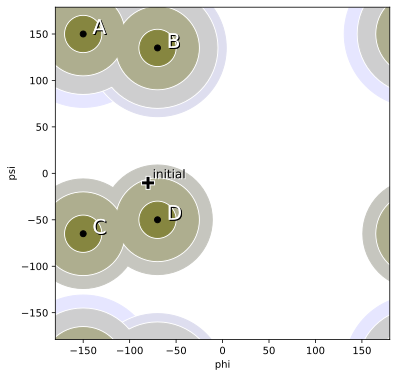

In [38]:
# reload(ala)
plot = ala.TwoCVSpherePlot(
    cvs=(phi, psi),
    states=[vol_state[vol] for vol in states],
    state_centers=[state_centers[vol] for vol in states],
    interface_levels=[interface_levels[vol] for vol in states]
)

plot.new()
# plot the phi/psi plot and show all states and interfaces
plot.main()
# add the initial template
plot.add_snapshot(template, label='initial')

### Set up the MSTIS network

We want to simulate using multistate transition interface sampling and to alleviate
the effort of setting up all states, interfaces, appropriate pathensembles and
a scheme on how to generate samples we use some helper construct like in the other
examples. In our case the `MSTISNetwork` comes first and contains the definitions of
all states, their interfaces as well as associated CVs.

To make use of the optional Multi-State Outer Interface `MSOuterInterface` we need to define it. It will allow reversing samples that connect two states and overcomes the issue that in all present moves the initial state needs to remain the same.

In [39]:
ms_outers = paths.MSOuterTISInterface.from_lambdas(
    {ifaces: max(ifaces.lambdas) + 4
     for state, ifaces in interface_sets.items()}
)

In [40]:
mstis = paths.MSTISNetwork([
    (vol_state[state], interface_sets[state])          # core, interface set
    for state in states],
    ms_outers=ms_outers
)

And save the network

In [41]:
storage.save(paths.Trajectory([template]))
storage.tag['network'] = mstis

### Set up the `MoveScheme`

Next, we need to specify the actual way in which we want to simulate the Network. This could be done by
constructing a suitable PathMover yourself or employing the power of a MoveScheme that will generate all nevessary movers for you. The MoveScheme also effectively knows which initial samples in which ensembles you need. Beside the ones indirectly defined by the network the movescheme might not need some of these because certain moves will not be used. It could also happen that a movescheme require an `extra` ensemble to work for special moves that are not directly known from the network definition.

In our case we will use the `DefaultScheme` that uses RepEx, Reversal, Shooting and MinusMoves.

In [42]:
scheme = paths.DefaultScheme(mstis)

### Initial trajectories

Next, we want to generate initial pathways for all ensembles, e.g. The `TISEnsembles` and `MinusInterfaceEnsembles`. There are several ways to do so. A very easy approach is to explore the state space at a high temperature and wait until all states have been visited. Splitting the long trajectory appropriately would give us at least one valid trajectory for each TIS ensemble. In a second step we can use over sub parts of the long trajectory and extend these into minus ensembles.

So let's try this: We generate an ensemble that is `True` if a trajectory is at least completely outside one state A-F. It will report false once all states have been hit, which is what we want. We will ues this as a stopping condition to generate a first long trajectory at high temperature.

In [43]:
state_volumes = list(vol_state.values())

In [44]:
visit_all_states = paths.join_ensembles([paths.AllOutXEnsemble(state) for state in state_volumes])

In [45]:
# trajectory = engine_high.generate(template, [hit_all_states.can_append])

This will take some time, even when running at a high temperature. Since this type of ensemble is quite common, and since we'd also like get progress updates while the trajectory is running, we created a specialized ensemble that wraps around the idea sketched out above. This ensemble gives a trajectory that will have visited all states, and reports progress while it is running.

In [46]:
visit_all_states = paths.VisitAllStatesEnsemble(state_volumes)

In [47]:
trajectory = engine_high.generate(template, [visit_all_states.can_append])

Ran 2157 frames. Found states [A,D,C,B]. Looking for [].


Output the long trajectory and see if we hit all states

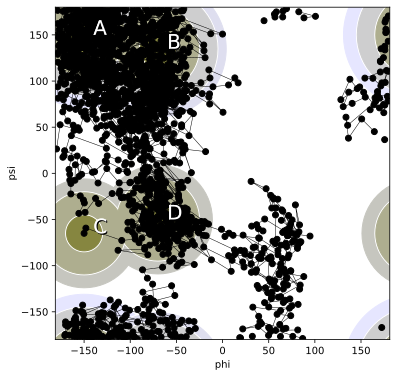

In [48]:
plot.new()
plot.main()
plot.add_trajectory(trajectory)

In [49]:
tps= paths.TPSNetwork.from_states_all_to_all(vol_state.values())
tps_ensemble = tps.sampling_ensembles[0]
trajectories = tps_ensemble.split(trajectory)

In [50]:
print(trajectories)

[Trajectory[63], Trajectory[35], Trajectory[74], Trajectory[37], Trajectory[33], Trajectory[210], Trajectory[62], Trajectory[94], Trajectory[57], Trajectory[68], Trajectory[28], Trajectory[15], Trajectory[34], Trajectory[126], Trajectory[215], Trajectory[73], Trajectory[81]]


### Find initial samples

It can be difficult to get initial samples for an ensemble for various reasons. And in fact for this example it might be the most tricky part in setting up the path simulation.

In theory you could just pick a frame and extend forward and backward until an ensemble reports cannot append anymore and check if that sample is in the ensemble. While this works in many cases it can be rather inefficient. For us it is better to reuse the previously computed trajectories as a basis to generate samples.


**Bottomline: The next command just does what you would try to do with the long trajectory for you: Use split and extend to generate the required set of samples to start.**

If you are interested in details keep reading, otherwise execute the next cell.

To do so, we use a number of functions from `Ensemble` that will try to generate a sample from a list of initial trajectories in different ways:

1. `ensemble.get_sample_from_trajectories` : directly search for candidate sample among the given trajectories
2. `ensemble.split_sample_from_trajectories` : split the given trajectories in valid samples
3. `ensemble.extend_sample_from_trajectories` : try to extend suitable sub-trajectories into valid samples

Instead of calling these functions directly we make use of a function from `MoveScheme` that uses its knowledge about the necessary ensembles to run these function for all necessary ensembles to create a suitable set of initial samples.

When doing this there are several aspects that we might want to take into account
1. also use reversed copies and try these
2. avoid reusing samples for better decorrelation.
3. try to use smaller trajectories as these are usually better equilibrated

The function `scheme.initial_conditions_from_trajectories` can take care of all of these. We will run it with the default setting but also use the `extend-complex` and `extend-minimum` strategies besides `split`. That means we try different strategies in a specific order.

1. `split`: try to split the trajectory and look for valid samples
2. `extend-complex`: try to look for suitable sub-trajectories that can be extended into valid samples. Currently this works only for `MinusInterfaceEnsembles` and it will extend `A-X-A` trajectories into Minus Ensembles.
3. `extend-minimum`: try to look for trajectories that cross an interface `A-X` and try to extend these into a full ensemble. This one will work for `TISEnsemble` and `MinusInterfaceEnsemble`. We will use this last method to create minus ensembles for the last state found. Since we stop when we discover it, we will not have generated a sample of type `A-X-A`. This might also happen if we only visit a state once.

Note, that the creation of sample might fail: Extending might just not reach the desired target state. By default, it will make 3 attempts per extendable subtrajectory. The whole process may take some time. Basically because we need to split a very long trajectory and to use the shortest possible ones we need to really search for all possible sub-trajectories.

In [51]:
total_sample_set = scheme.initial_conditions_from_trajectories(
    trajectories)

Missing ensembles:
*  [Out A minus]
*  [Out B minus]
*  [Out C minus]
*  [Out D minus]
No extra ensembles.


Let's see, if we were successful. If so, the next function should not show any missing or extra ensembles.

In [52]:
print(scheme.initial_conditions_report(total_sample_set))

Missing ensembles:
*  [Out A minus]
*  [Out B minus]
*  [Out C minus]
*  [Out D minus]
No extra ensembles.



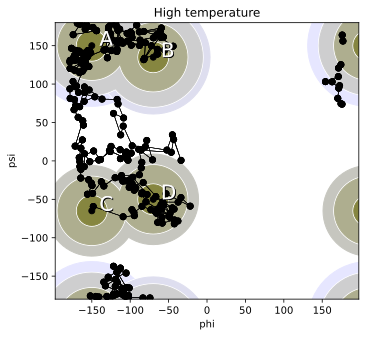

In [53]:
plt.figure(21, (12,5))
plt.subplot(121)
plt.title('High temperature')
plot.main()
for s in total_sample_set:
    plot.add_trajectory(s.trajectory, line=True)


If it does, this means that our attempt to extend was probably not successful. So we can just try again until it does. To extend an existing sample_set you need to pass it to the function.

In [54]:
# loop until we are done
while scheme.check_initial_conditions(total_sample_set)[0]:
    total_sample_set = scheme.initial_conditions_from_trajectories(
        trajectory,
        sample_set=total_sample_set,  # this is new
        strategies=[  # we omit the `split` strategy
            'extend-complex',
            'extend-minimal'],
        engine=engine_high)

No missing ensembles.
No extra ensembles.


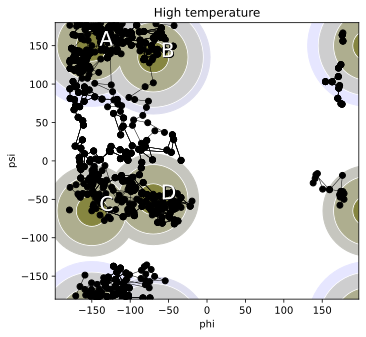

In [55]:
plt.figure(21, (12,5))
plt.subplot(121)
plt.title('High temperature')
plot.main()
for s in total_sample_set:
    plot.add_trajectory(s.trajectory, line=True)


Done.

## Equilibration

For the next steps we need the engine running at the desired (room) temperature. So we create a new engine.
Since we might run on a local machine and do not have several instances of GPU available we will unload the
existing engine and create a new one.

In [56]:
engine_high.unload_context()  # delete the current openmm.Context object
engine_low.initialize(platform)

refresh_output('Low-Engine uses', refresh=False)
print('platform `%s`' % engine_low.platform)
print('temperature `%6.2f K' % (
    float(engine_low.integrator.getGlobalVariableByName('kT')) / 0.0083144621))

Low-Engine usesplatform `CUDA`
temperature `300.00 K


In molecular dynamics, you need to equilibrate if you don't start with an equilibrium frame (e.g., if you start with solvent molecules on a grid, your system should equilibrate before you start taking statistics). Similarly, if you start with a set of paths which are far from the path ensemble equilibrium, you need to equilibrate. This could either be because your trajectories are not from the real dynamics (generated with metadynamics, high temperature, etc.) or because your trajectories are not likely representatives of the path ensemble (e.g., if you put transition trajectories into all interfaces).

As with MD, running equilibration can be the same process as running the total simulation. However, in path sampling, it doesn't have to be: we can equilibrate without replica exchange moves or path reversal moves, for example. In the example below, we create a `MoveScheme` that only includes shooting movers.

In [57]:
equil_scheme = paths.OneWayShootingMoveScheme(mstis, engine=engine_low)

Note, that some Schemes may change the actual required set of initial samples. For
the equilibration we apply shooting moves only to TIS ensembles and not to the
`MinusInterfaceEnsemble`s.

Create the PathSampler object that can run the equilibration.

In [58]:
equilibration = paths.PathSampling(
    storage=storage,
    sample_set=total_sample_set,
    move_scheme=equil_scheme,
)

And run lots of equilibration steps. This is not really necessary, but
we generated from the wrong path distribution and this should give more likeli
paths for the right temperature.

In [59]:
equilibration.run(500)
equilibrated_sset = equilibration.sample_set

Working on Monte Carlo cycle number 500
Running for 4 minutes 56 seconds -  0.59 seconds per step
Estimated time remaining: 0 seconds
DONE! Completed 500 Monte Carlo cycles.


Let's have a quick look how many frames in TIS ensembles are already generated by the default engine at `300K` and how many were done using the `high` engine at `1000K`.

In [60]:
engine_list = {}

unique_snapshots = set(sum(
    [
        samp.trajectory for samp in equilibrated_sset
        if isinstance(samp.ensemble, paths.TISEnsemble)
    ],
    []))

for samp in equilibrated_sset:
    if isinstance(samp.ensemble, paths.TISEnsemble):
        for snap in samp.trajectory:
            eng = snap.engine
            engine_list[eng] = engine_list.get(eng, 0) + 1

for eng, counts in engine_list.items():
    print('%20s : %6d' % (eng.name, counts))

             default :    629


Finally, save the list of samples for later without any reference to previous samples. This is necessary since usually a sample knows its origin sample and saving a sample as is, would trigger saving the whole history of all intermediate samples used. Since we are not interested in the history of equilibration, this saves a lot of storage.

In [61]:
storage.tag['sampleset'] = equilibrated_sset.copy_without_parents()

Let's have a final look at what we cover with all our initial samples.

In [62]:
for s in total_sample_set:
    print(s)

Sample(RepID: 0, Ens: <openpathsampling.ensemble.TISEnsemble object at 0x7ff9800f6fe0>, Trajectory[35])
Sample(RepID: 1, Ens: <openpathsampling.ensemble.TISEnsemble object at 0x7ff980120700>, Trajectory[35])
Sample(RepID: 2, Ens: <openpathsampling.ensemble.TISEnsemble object at 0x7ff980121570>, Trajectory[35])
Sample(RepID: 3, Ens: <openpathsampling.ensemble.TISEnsemble object at 0x7ff9801223e0>, Trajectory[35])
Sample(RepID: 4, Ens: <openpathsampling.ensemble.TISEnsemble object at 0x7ff9801315d0>, Trajectory[74])
Sample(RepID: 5, Ens: <openpathsampling.ensemble.TISEnsemble object at 0x7ff980132440>, Trajectory[74])
Sample(RepID: 6, Ens: <openpathsampling.ensemble.TISEnsemble object at 0x7ff9801332b0>, Trajectory[74])
Sample(RepID: 7, Ens: <openpathsampling.ensemble.TISEnsemble object at 0x7ff980134160>, Trajectory[74])
Sample(RepID: 8, Ens: <openpathsampling.ensemble.TISEnsemble object at 0x7ff980137310>, Trajectory[81])
Sample(RepID: 9, Ens: <openpathsampling.ensemble.TISEnsemble obj

In [63]:
for s in equilibrated_sset:
    print(s)

Sample(RepID: 14, Ens: <openpathsampling.ensemble.UnionEnsemble object at 0x7ff9801608e0>, Trajectory[63])
Sample(RepID: 15, Ens: <openpathsampling.ensemble.MinusInterfaceEnsemble object at 0x7ff9800f7100>, Trajectory[54])
Sample(RepID: 16, Ens: <openpathsampling.ensemble.MinusInterfaceEnsemble object at 0x7ff980123970>, Trajectory[85])
Sample(RepID: 17, Ens: <openpathsampling.ensemble.MinusInterfaceEnsemble object at 0x7ff980142590>, Trajectory[29])
Sample(RepID: 18, Ens: <openpathsampling.ensemble.MinusInterfaceEnsemble object at 0x7ff9801372b0>, Trajectory[89])
Sample(RepID: 5, Ens: <openpathsampling.ensemble.TISEnsemble object at 0x7ff980132440>, Trajectory[41])
Sample(RepID: 2, Ens: <openpathsampling.ensemble.TISEnsemble object at 0x7ff980121570>, Trajectory[61])
Sample(RepID: 12, Ens: <openpathsampling.ensemble.TISEnsemble object at 0x7ff98014d090>, Trajectory[33])
Sample(RepID: 13, Ens: <openpathsampling.ensemble.TISEnsemble object at 0x7ff98014df00>, Trajectory[38])
Sample(RepI

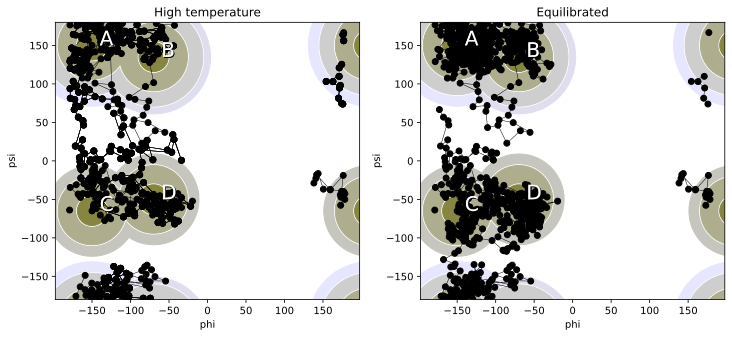

In [64]:
plt.figure(21, (12,5))
plt.subplot(121)
plt.title('High temperature')
plot.main()
for s in total_sample_set:
    plot.add_trajectory(s.trajectory, line=True)

plt.subplot(122)
plt.title('Equilibrated')
plot.main()
plot.zoom = 180/3.1415926
for s in equilibrated_sset:
    plot.add_trajectory(s.trajectory, line=True)

A final check that we still have a valid sampleset

In [65]:
equilibrated_sset.sanity_check()

In [66]:
print('snapshots:', len(storage.snapshots))
print('trajectories:', len(storage.trajectories))
print('samples:', len(storage.samples))
print('filesize:', storage.file_size_str)

snapshots: 40242
trajectories: 509
samples: 538
filesize: 899.54MB


In [67]:
storage.close()